## 1. Obter o Dataset

O dataset ``Hate Speech and Offensive Language Dataset`` utilizado para a classificação de texto pode ser baixado do **Kaggle**, o link você pode encontrar clicando [aqui](https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset?resource=download), assim como o paper original da aplicação você pode encontrar [aqui](https://arxiv.org/pdf/1703.04009).

### Aplicação

Um desafio inerente ao contexto de redes sociais é a classificação automática de instâncias de textos tóxicos, tais como o discurso de ódio e a linguagem ofensiva. Nesse sentido, a classificação automática se torna uma tarefa fundamental para a identificação de conteúdo nocivo e a proteção de usuários vulneráveis. Neste projeto, utilizamos um dataset de classificação de texto para treinar um modelo de classificação de texto capaz de identificar automaticamente conteúdo tóxico em redes sociais com base em tweets.


In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

import string

# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler


# Inicializa o lemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('omw-1.4')  # Para outras línguas, se necessário
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load the data
data = pd.read_csv('../data/labeled_data.csv')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Pré-processamento

A pipeline completa foi dividida em duas etapas: ``prepro_features`` e  ``pipeline``. A primeira etapa é responsável por realizar o pré-processamento dos dados, enquanto a segunda etapa é responsável por treinar o modelo de classificação e avaliar seu desempenho. 

Para o pré-processamento dos textos, foram utilizadas as seguintes técnicas:

- Remoção de stopwords e pontuação
- Lematização
- Vetorização com TF-IDF

Dessa forma, a implementação você pode acompanhar abaixo:

In [139]:
class PreproTweets(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [self.preprocess_text(text) for text in X]

    def preprocess_text(self, text):
        # print(text)
        text = text.lower()
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'\b\w{1,2}\b', '', text)  
        text = re.sub(r'[^\w\s]', '', text) 
        text = ' '.join(lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words)
        return text

# Exemplo de pipeline com pré-processamento e TF-IDF
pipeline_prepro_features = Pipeline([
    ('prepro', PreproTweets()),
    ('tfidf', TfidfVectorizer()),
])

pipeline = Pipeline([
    ('prepro_features', pipeline_prepro_features),
    ('log_reg', LogisticRegression()),
])

texts, target = data['tweet'], data['class']

X, y = texts, target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [140]:
# Treinando a pipeline com X e y
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prepro_features',
                 Pipeline(steps=[('prepro', PreproTweets()),
                                 ('tfidf', TfidfVectorizer())])),
                ('log_reg', LogisticRegression())])

In [141]:
# Fazendo previsões e avaliando o modelo
y_pred = pipeline.predict(X_test)

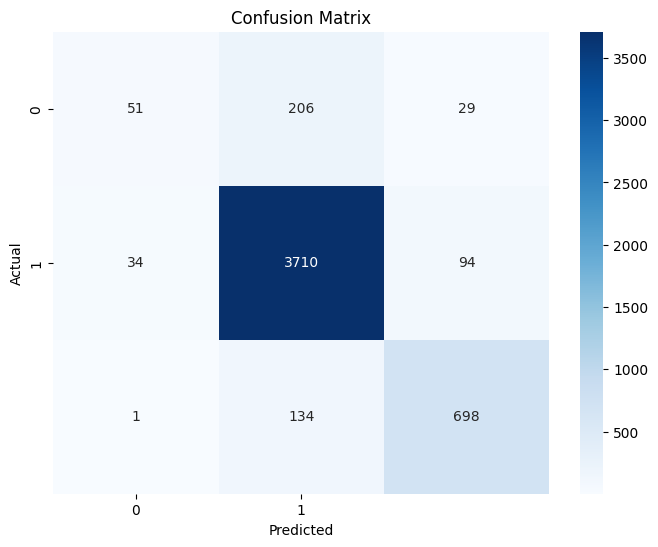

In [142]:
# confusion matrix 

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [143]:
# precision, recall e f1-score

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.59      0.18      0.27       286
           1       0.92      0.97      0.94      3838
           2       0.85      0.84      0.84       833

    accuracy                           0.90      4957
   macro avg       0.79      0.66      0.69      4957
weighted avg       0.89      0.90      0.89      4957



## Junção de classes

Devido a complexidade envolvida em classificar **hate speech e offensive language**, vamos considerar a classificação de **offensive language & hate speech** como sendo uma só (0), transformando o problema numa classificação binária. O intuito dessa abordagem é simplificar o problema e tornar o modelo mais eficiente.

### Antes:

0 - Hate Speech

1 - Offensive Language

2 - Neither

### Depois:

0 - Hate Speech & Offensive Language

1 - Neither

## Equilibrando datasets

Além disso, vamos também equilibrar os datasets para que o modelo não seja enviesado para uma classe específica. Para isso, vamos utilizar a técnica de **undersampling**.

In [144]:
pipeline_prepro_features = Pipeline([
    ('prepro', PreproTweets()),
    ('tfidf', TfidfVectorizer()),
])

pipeline = Pipeline([
    ('prepro_features', pipeline_prepro_features),
    ('log_reg', LogisticRegression()),
])

texts, target = data['tweet'], data['class']

target = target.apply(lambda x: x//2)
texts_target = pd.concat([texts, target], axis=1)

down_sample = target.value_counts().min()
texts_target_undersampled = pd.concat([texts_target[texts_target['class'] == 0].sample(down_sample, random_state=42),
                                        texts_target[texts_target['class'] == 1]])

X, y = texts_target_undersampled['tweet'], texts_target_undersampled['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [145]:
# Treinando a pipeline com X e y
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prepro_features',
                 Pipeline(steps=[('prepro', PreproTweets()),
                                 ('tfidf', TfidfVectorizer())])),
                ('log_reg', LogisticRegression())])

In [146]:
# Fazendo previsões e avaliando o modelo
y_pred = pipeline.predict(X_test)

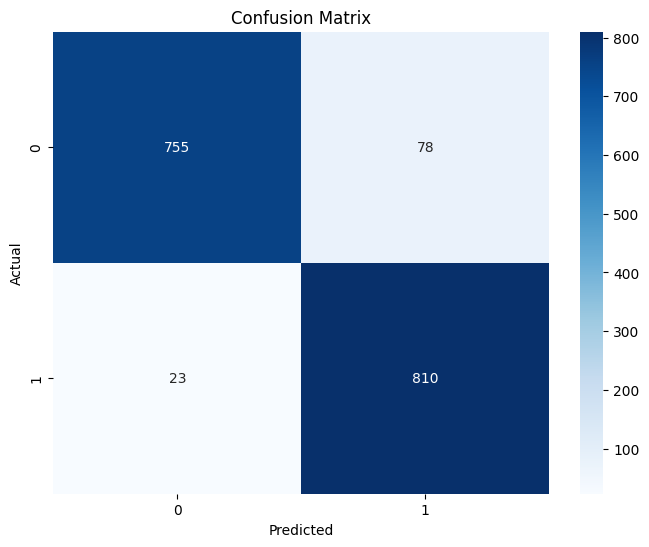

In [147]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [148]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       833
           1       0.91      0.97      0.94       833

    accuracy                           0.94      1666
   macro avg       0.94      0.94      0.94      1666
weighted avg       0.94      0.94      0.94      1666



In [149]:
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

print(f'F1 Score: {f1_score(y_test, y_pred)}')
print(f'Recall Score: {recall_score(y_test, y_pred)}')
print(f'Precision Score: {precision_score(y_test, y_pred)}')
print(f'Accuracy Score: {accuracy_score(y_test, y_pred)}')

F1 Score: 0.9413131900058106
Recall Score: 0.9723889555822329
Precision Score: 0.9121621621621622
Accuracy Score: 0.93937575030012


## Como identificar instâncias confusas?

Vamos ordenar as instâncias de acordo com a entropia de suas probabilidades, dessa forma, as instâncias que o modelo tem mais dificuldade de classificar serão as primeiras a serem analisadas.

In [185]:
def func_entropy(p):
    return np.sum([-p_i * np.log2(p_i) for p_i in p], axis=1)

In [195]:
entropy = func_entropy(pipeline.predict_proba(X_test))
p = pipeline.predict_proba(X_test)[:, 0]

In [196]:
df = pd.DataFrame({'tweet': X_test, 'class': y_test, 'entropy': entropy, 'p_hate_offensive': p})

In [202]:
df.sort_values('entropy', ascending=False).head(10)

,tweet,class,entropy,p_hate_offensive
13362,Niggas/bitches cheat cause mf's always think t...,0,0.999991,0.501756
10895,I sound retarded but he is learning quickly! @...,0,0.999924,0.505118
19870,RT @psjohnson23: The problem with retard liber...,0,0.999914,0.494552
23842,fucking hot boots. Who doesnt love a boot boy....,0,0.999902,0.505833
12660,Looks like a tool but is useful as a clay hamm...,1,0.999875,0.493405
17790,RT @TittyFlex: Lol I don't need Halloween to d...,0,0.999861,0.493055
14010,"RT @215potter: Grown men, wearing jerseys with...",0,0.999795,0.508423
13420,Nobody on planet Earth more protective than bu...,0,0.999565,0.512280
20254,RT @tyler_yost: You guys are all the best @bro...,0,0.999357,0.485074
846,#milesthompson #goauche #wetback #ca http://t....,0,0.999256,0.516055


In [203]:
for idx, t in enumerate(df.sort_values('entropy', ascending=False)[['tweet', 'class', 'p_hate_offensive']].values[:10]):
    if t[1] == 0:
        classe = 'hate/offensive'
    else:
        classe = 'non-hate/offensive'
    print('Tweet: ', t[0])
    print('Class: ', classe)
    print('Probabilidade de ser hate/offensive: ', t[2])
    print('\n\n---------------------------\n\n')

Tweet:  Niggas/bitches cheat cause mf's always think they gettin played
Class:  hate/offensive
Probabilidade de ser hate/offensive:  0.5017559045789473


---------------------------


Tweet:  I sound retarded but he is learning quickly! @tyler_yost http://t.co/4vqH4zBwml
Class:  hate/offensive
Probabilidade de ser hate/offensive:  0.5051179509046089


---------------------------


Tweet:  RT @psjohnson23: The problem with retard liberals is they think Supply &amp; Demand means "Supply me with everything I Demand." #VotingMatters
Class:  hate/offensive
Probabilidade de ser hate/offensive:  0.4945520294358482


---------------------------


Tweet:  fucking hot boots. Who doesnt love a boot boy. Lick those soles clean. http://t.co/tHnVlldUt8
Class:  hate/offensive
Probabilidade de ser hate/offensive:  0.5058327315984394


---------------------------


Tweet:  Looks like a tool but is useful as a clay hammer #fag @hOPPondis http://t.co/K7wqlAWRwM
Class:  non-hate/offensive
Probabilidade de

## 3. Avaliação do Classificador

Para garantir uma avaliação robusta do modelo, foi utilizada a **validação cruzada com K-Folds**, onde o conjunto de dados é dividido em 100 subconjuntos ou "folds". A cada iteração, o modelo é treinado em 99 desses folds e testado no fold restante, repetindo esse processo até que todos os folds sejam utilizados como conjunto de teste exatamente uma vez. O uso de 100 folds ajuda a reduzir a variabilidade associada à partição do conjunto de dados e oferece uma estimativa mais estável das métricas de desempenho. As principais métricas de avaliação incluídas são **F1-Score, acurácia, precisão e revocação**, cujas médias e desvios-padrão são calculados ao longo de todas as iterações para fornecer uma visão mais clara da performance do modelo.

Além disso, foi gerado gráficos da distribuição de cada métrica para cada fold, a fim de identificar possíveis variações no desempenho do modelo em diferentes subconjuntos de dados. A seguir, são apresentados os resultados obtidos para o modelo de classificação.


In [ ]:
X_original = X.copy()
y_original = y.copy()

In [151]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from tqdm import tqdm

# Defina o número de folds
kfold = KFold(n_splits=100, shuffle=True, random_state=42)

X = X_original.reset_index(drop=True)
y = y_original.reset_index(drop=True)

# Para armazenar os resultados de cada fold
f1s = []
accuracies = []
recalls = []
precisions = []

def create_model():
    pipeline_prepro_features = Pipeline([
        ('prepro', PreproTweets()),
        ('tfidf', TfidfVectorizer()),
    ])

    pipeline = Pipeline([
        ('prepro_features', pipeline_prepro_features),
        ('log_reg', LogisticRegression()),
    ])

    return pipeline

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    return f1, accuracy, precision, recall

# Validação cruzada para o modelo LLM
for train_idx, test_idx in tqdm(kfold.split(X, y)):
    X_train_cv, X_test_cv = X.loc[train_idx], X.loc[test_idx]
    y_train_cv, y_test_cv = y[train_idx], y[test_idx]
    
    pipeline = create_model()
    
    pipeline.fit(X_train_cv, y_train_cv)
    
    f1, accuracy, precision, recall = evaluate_model(pipeline, X_test_cv, y_test_cv)
    
    f1s.append(f1)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    
# Exibindo as métricas finais como distribuições
print(f'F1: {np.mean(f1s):.2f} +/- {np.std(f1s):.2f}')
print(f'Accuracy: {np.mean(accuracies):.2f} +/- {np.std(accuracies):.2f}')
print(f'Precision: {np.mean(precisions):.2f} +/- {np.std(precisions):.2f}')
print(f'Recall: {np.mean(recalls):.2f} +/- {np.std(recalls):.2f}')

100it [01:32,  1.08it/s]

F1: 0.95 +/- 0.03
Accuracy: 0.94 +/- 0.03
Precision: 0.92 +/- 0.04
Recall: 0.98 +/- 0.02


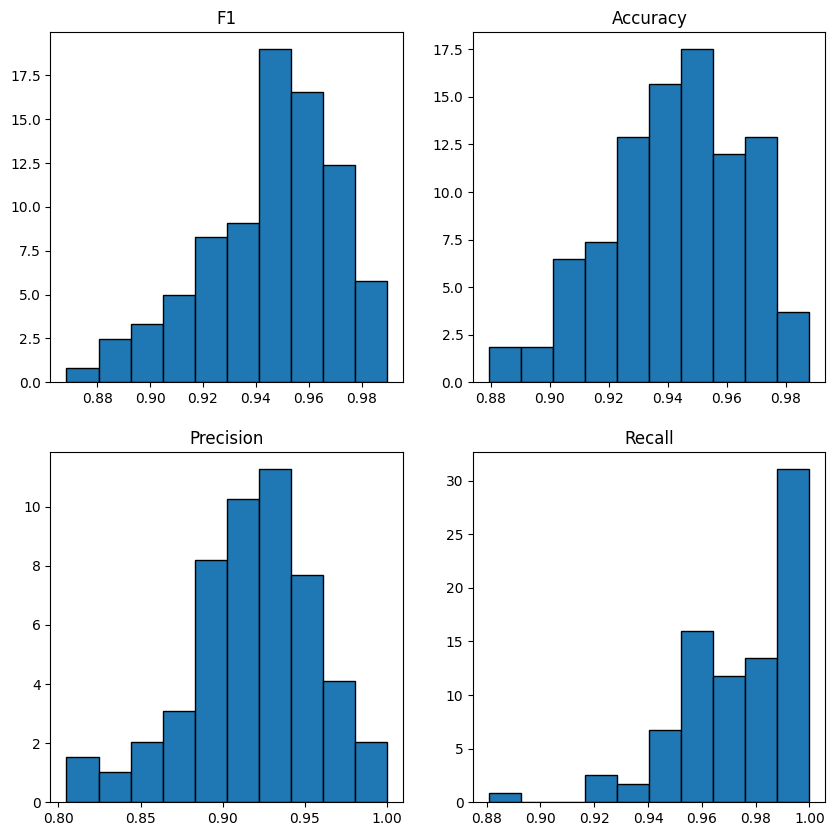

In [152]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # Cria dois subplots lado a lado

for ax, metric, name in zip(axes.flatten(), [f1s, accuracies, precisions, recalls], ['F1', 'Accuracy', 'Precision', 'Recall']):
    ax.hist(metric, bins=10, edgecolor='black', density=True)
    ax.set_title(name)
plt.show()

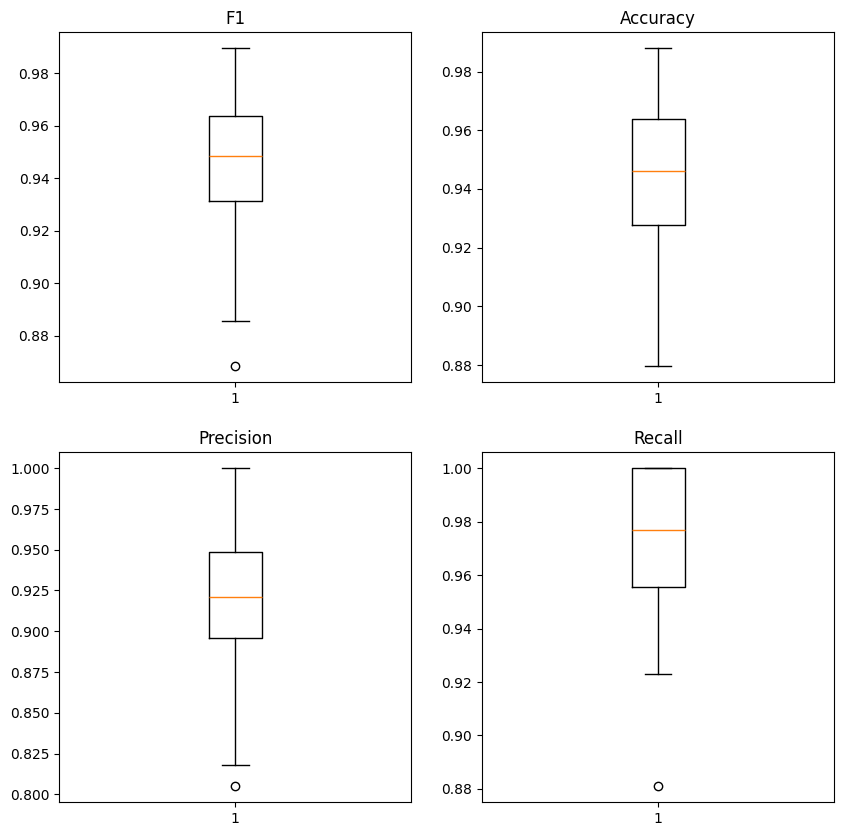

In [204]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # Cria dois subplots lado a lado

for ax, metric, name in zip(axes.flatten(), [f1s, accuracies, precisions, recalls], ['F1', 'Accuracy', 'Precision', 'Recall']):
    ax.boxplot(metric)
    
    ax.set_title(name)
plt.show()

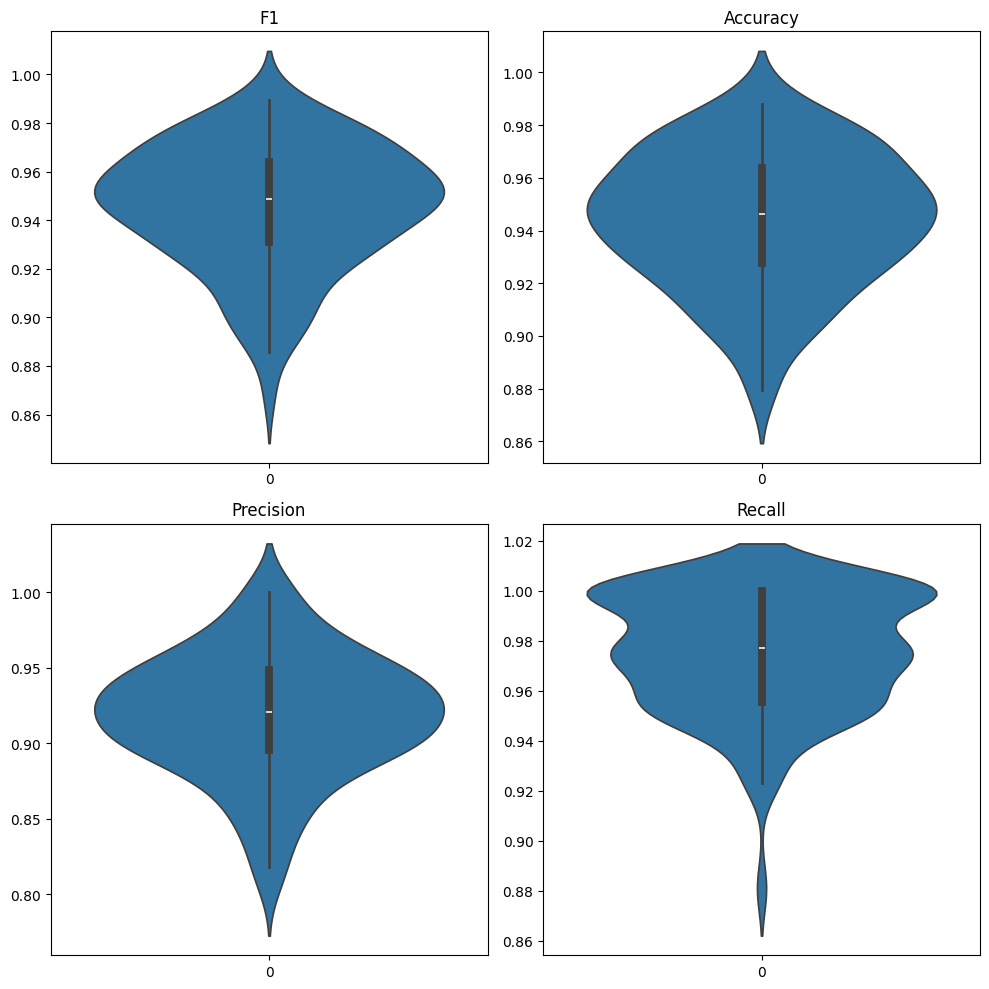

In [205]:
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # Cria dois subplots lado a lado

# Violin plot with sns
for ax, metric, name in zip(axes.flatten(), [f1s, accuracies, precisions, recalls], ['F1', 'Accuracy', 'Precision', 'Recall']):
    sns.violinplot(data=[metric], ax=ax)
    
    ax.set_title(name)
plt.tight_layout()
plt.show()

In [206]:
# Extrai as etapas necessárias
tfidf = pipeline.named_steps['prepro_features'].named_steps['tfidf']
log_reg = pipeline.named_steps['log_reg']

# Obtém os nomes das features
feature_names = tfidf.get_feature_names_out()

# Obtém os coeficientes da Regressão Logística
log_reg_coefficients = log_reg.coef_[0]

# Calcula a importância das palavras
word_importance = log_reg_coefficients

In [213]:
# Número de palavras para exibir
top_n = 10

# Índices das palavras com maior contribuição positiva
top_positive_indices = word_importance.argsort()[-top_n:]

# Índices das palavras com maior contribuição negativa
top_negative_indices = word_importance.argsort()[:top_n]

print("Palavras que mais contribuem positivamente para a classe alvo:")
for idx in reversed(top_positive_indices):
    print(f"{feature_names[idx]}: {word_importance[idx]:.4f}")

print("\nPalavras que mais contribuem negativamente (associadas à classe oposta):")
for idx in top_negative_indices:
    print(f"{feature_names[idx]}: {word_importance[idx]:.4f}")

Palavras que mais contribuem positivamente para a classe alvo:
bird: 5.8814
trash: 5.6385
yankee: 4.9584
charlie: 4.4743
yellow: 4.2395
oreo: 3.2637
brownie: 3.1533
monkey: 2.6483
mock: 2.5598
colored: 2.4811

Palavras que mais contribuem negativamente (associadas à classe oposta):
bitch: -20.3141
hoe: -11.0728
pussy: -9.5015
shit: -5.6626
faggot: -5.4129
as: -5.0832
nigga: -4.9130
fuck: -4.8490
fag: -4.4652
nigger: -4.3939


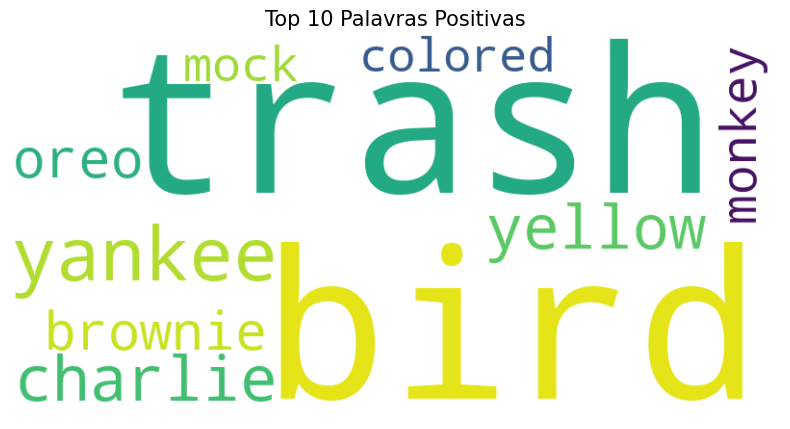

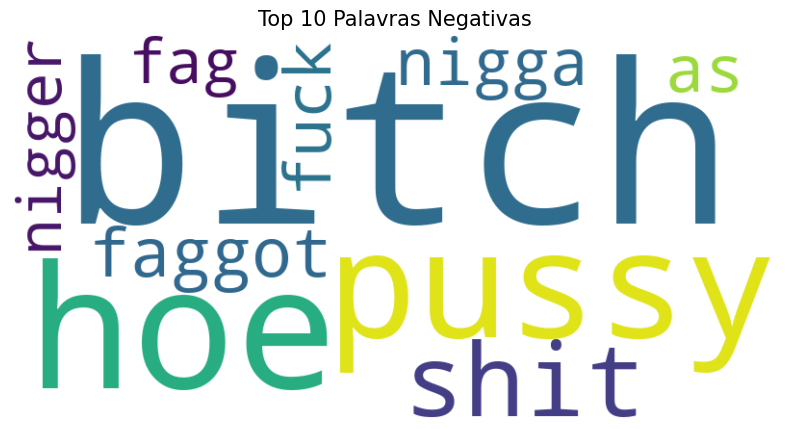

In [209]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

positive_words = {feature_names[idx]: word_importance[idx] for idx in top_positive_indices}
negative_words = {feature_names[idx]: abs(word_importance[idx]) for idx in top_negative_indices}

def generate_wordcloud(word_dict, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_dict)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.show()

generate_wordcloud(positive_words, "Top 10 Palavras Positivas")
generate_wordcloud(negative_words, "Top 10 Palavras Negativas")

## Modificando o tamanho do dataset

Vamos variar o tamanho do dataset gradativamente para enxergar o comportamento dos gráficos e das métricas de avaliação.

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [04:21<00:00, 13.06s/it]


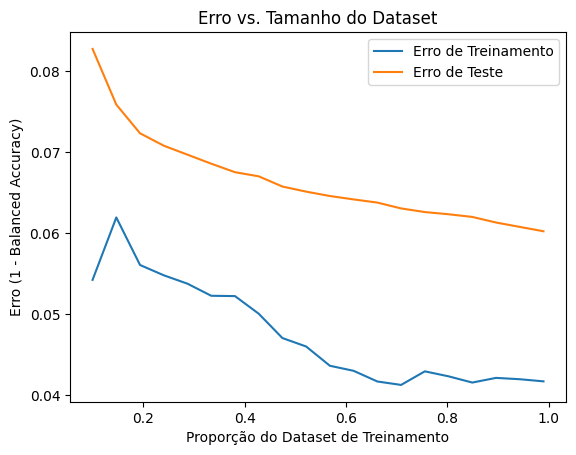

In [214]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt

# Listas para armazenar os resultados
train_sizes = np.linspace(0.1, 0.99, 20)
train_errors = []
test_errors = []

for train_size in tqdm(train_sizes):
    pipelines = []
    for k in range(20):
        # Downsampling do dataset
        X_train_sampled, _, y_train_sampled, _ = train_test_split(X_train,
                                                                y_train,
                                                                test_size=1-train_size,
                                                                random_state=42 + k * 5 + int(train_size * 100),
                                                                stratify=y_train)
        
        # Treina o modelo com o subset dos dados
        pipeline = create_model()
        pipeline.fit(X_train_sampled, y_train_sampled)
        pipelines.append(pipeline)
    
    # Calcula o erro de treinamento
    train_error = 1 - np.mean([balanced_accuracy_score(y_train_sampled, pipeline.predict(X_train_sampled)) for pipeline in pipelines])
    train_errors.append(train_error)
    
    # Calcula o erro de teste
    test_error = 1 - np.mean([balanced_accuracy_score(y_test, pipeline.predict(X_test)) for pipeline in pipelines])
    test_errors.append(test_error)
    

# Plotagem dos erros
plt.plot(train_sizes, train_errors, label='Erro de Treinamento')
plt.plot(train_sizes, test_errors, label='Erro de Teste')
plt.xlabel('Proporção do Dataset de Treinamento')
plt.ylabel('Erro (1 - Balanced Accuracy)')
plt.title('Erro vs. Tamanho do Dataset')
plt.legend()
plt.show()


## Conclusão parcial

Note que algumas palavras não fazem sentido estar lá. Para isso, podemos expandir a lista de stopwords.

In [78]:
stop_words_custom = set(stop_words).union({})

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [58]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_pipeline_1 = Pipeline([('prepro', PreproTweets()),
                                ('vectorizer', CountVectorizer(binary=True))])

vectorizer_pipeline_0 = Pipeline([('prepro', PreproTweets()),
                                  ('vectorizer', CountVectorizer(binary=True))])

X_count_1 = vectorizer_pipeline_1.fit_transform(X_train[y_train == 1]).sum(axis=0)
X_count_0 = vectorizer_pipeline_0.fit_transform(X_train[y_train == 0]).sum(axis=0)

X_count_1[0].shape, X_count_0[0].shape, vectorizer_pipeline_1['vectorizer'].get_feature_names_out().shape, vectorizer_pipeline_0['vectorizer'].get_feature_names_out().shape

((1, 10464), (1, 7564), (10464,), (7564,))

In [59]:
def print_words_count(count, vectorizer, k=5):
    words = vectorizer.get_feature_names_out()
    for i in count.argsort()[-k:]:
        print(words[i])
    print()

In [65]:
print('Palavras mais comuns para a classe 1:')
print_words_count(np.array(X_count_1)[0], vectorizer_pipeline_1['vectorizer'], k=20)

print('-'*50)

print('Palavras mais comuns para a classe 0:')
print_words_count(np.array(X_count_0)[0], vectorizer_pipeline_0['vectorizer'], k=20)

Palavras mais comuns para a classe 1:
look
know
monkey
got
make
http
colored
oreo
brownie
ghetto
lol
one
amp
get
yellow
charlie
like
yankee
bird
trash

--------------------------------------------------
Palavras mais comuns para a classe 0:
look
faggot
amp
want
one
girl
fucking
love
know
lol
got
get
shit
fuck
as
nigga
pussy
like
hoe
bitch

